In [114]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.nn.functional as F

In [115]:
%load_ext autoreload

In [116]:
%autoreload 2

# pytorch-grad-cam.git

In [117]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [118]:
from src.neural_network import DeepSymNet

In [119]:
path_model = "/home/high_fly_bird/workspace/Ischemic_Stroke_Prediction/lightning_logs/ish_lr_best/checkpoints/last.ckpt"
model = DeepSymNet.load_from_checkpoint(path_model)

In [120]:
target_layers = [model.shared_tunnel[-2]]

In [121]:
pred

tensor([[5.4432]], grad_fn=<AddmmBackward0>)

In [122]:
img.shape

torch.Size([1, 1, 128, 98])

In [123]:
targets = [ClassifierOutputTarget(0)]


In [124]:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

In [125]:
grayscale_cam = cam(input_tensor=img, targets=None)

TypeError: 'numpy.int64' object is not iterable

# Other

In [ ]:

from src.CTDataModule import CTDataModule

import pytorch_lightning as pl

from src.predictions import get_test_predictions

In [ ]:
path_model = "/home/high_fly_bird/workspace/Ischemic_Stroke_Prediction/lightning_logs/ish_lr_best/checkpoints/last.ckpt"
model = DeepSymNet.load_from_checkpoint(path_model)

In [ ]:
model.eval()

DeepSymNet(
  (siamese_part): SiameseAndDifferenceBlock(
    (inception_chain): Sequential(
      (0): InceptionBlock(
        (branch_1filter): ConvBlock(
          (conv): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (branch_3filter): Sequential(
          (0): ConvBlock(
            (conv): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): ConvBlock(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (branch_5filter): Sequential(
          (0): ConvBlock(
            (conv): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [ ]:
test_dir = "/home/martinumer/IschemicData/test"
dm_predict = CTDataModule(data_dir=test_dir,
                              batch_size=1,
                              num_workers=6,
                              test_shuffle=False)
dm_predict.setup('test')
dataloader = dm_predict.test_dataloader()
dataloader_iter = iter(dataloader)

img, label = next(dataloader_iter)

In [ ]:
while label != 1:
    img, label = next(dataloader_iter)


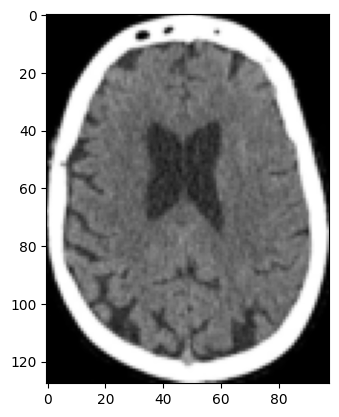

In [ ]:
from src.utils import show_tensor
show_tensor(img[0])

In [ ]:
img.size()

torch.Size([1, 1, 128, 98])

In [ ]:
# # get the most likely prediction of the model
# pred = model(img)
# pred

In [ ]:
list(model.children())[0]

SiameseAndDifferenceBlock(
  (inception_chain): Sequential(
    (0): InceptionBlock(
      (branch_1filter): ConvBlock(
        (conv): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (branch_3filter): Sequential(
        (0): ConvBlock(
          (conv): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): ConvBlock(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (branch_5filter): Sequential(
        (0): ConvBlock(
          (conv): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): ConvBlock(
 

In [ ]:
img.shape

torch.Size([1, 1, 128, 98])

In [ ]:
# активации свёрточных слоёв
x = list(model.children())[0](img)
layer_activations = list(model.children())[1](x)
layer_activations_flat = layer_activations.view(layer_activations.size()[0], -1)
layer_activations.grad_fn

In [ ]:
# предсказание
pred = list(model.children())[2](layer_activations_flat)
# pred = nn.Sigmoid()(pred)
# pred = pred.reshape(pred.shape[0])
pred

tensor([[5.4432]], grad_fn=<AddmmBackward0>)

In [ ]:
pred

tensor([[5.4432]], grad_fn=<AddmmBackward0>)

In [ ]:
from torch import autograd

grads = autograd.grad(pred, layer_activations) # ??

In [ ]:
grads[0].shape

torch.Size([1, 256, 43, 17])

In [ ]:
pooled_grads = grads[0].mean((0,2,3))

pooled_grads.shape

torch.Size([256])

In [ ]:
conv_output = layer_activations.squeeze()

conv_output = F.relu(conv_output)

conv_output.shape



torch.Size([256, 43, 17])

In [ ]:
for i in range(len(pooled_grads)):
    conv_output[i,:,:] *= pooled_grads[i]

In [ ]:
heatmap = conv_output.mean(dim=0).squeeze()

## Normalize heatmap
#heatmap = F.relu(heatmap) / torch.max(heatmap)
heatmap = heatmap / torch.max(heatmap)

heatmap.shape

torch.Size([43, 17])

In [ ]:
img.shape

torch.Size([1, 1, 128, 98])

In [ ]:
heatmap.shape

torch.Size([43, 17])

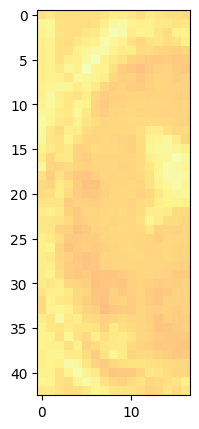

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# create a figure with a single subplot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# plot the image and heatmap
# ax.imshow(img[0][ :, :, :(98 // 2)].permute(1, 2, 0)[:, :, 0].detach().numpy(), cmap='gray')
ax.imshow(heatmap.detach().numpy(), cmap='Wistia', alpha=0.5, interpolation='nearest', zorder=2)

# show the plot
plt.show()

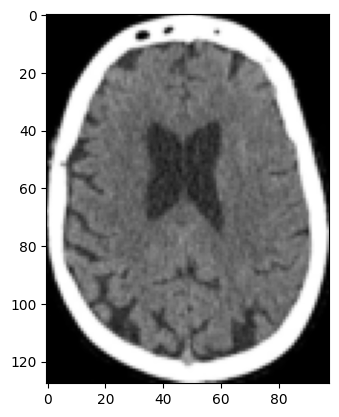

In [108]:
show_tensor(img[0])

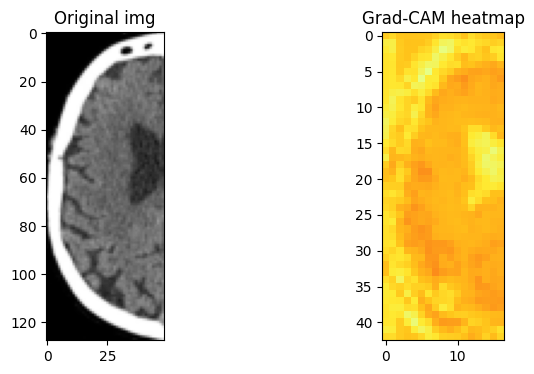

In [126]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.imshow(img[0][ :, :, :(98 // 2)].permute(1, 2, 0)[:, :, 0].detach().numpy(), cmap='gray')
ax1.set_title('Original img')
# more orange means the highest values
ax2.imshow(heatmap.detach().numpy(), cmap='Wistia', alpha=0.9, interpolation='nearest')
ax2.set_title('Grad-CAM heatmap')
plt.show()


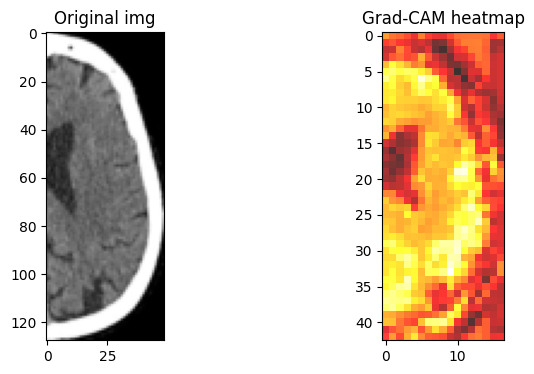

In [127]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.imshow(img[0][ :, :, (98 // 2):].permute(1, 2, 0)[:, :, 0].detach().numpy(), cmap='gray')
ax1.set_title('Original img')
# white means the highest values
ax2.imshow(torch.flip(heatmap, dims=[1]).detach().numpy(), cmap='hot', alpha=0.8, interpolation='nearest')
ax2.set_title('Grad-CAM heatmap')
plt.show()


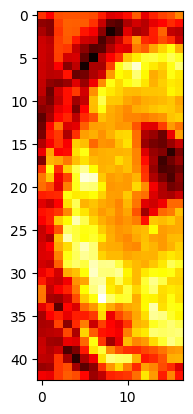

In [57]:
plt.imshow(heatmap.detach().numpy(), cmap='hot')

In [53]:
heatmap.shape

torch.Size([43, 17])

In [51]:
img.shape

torch.Size([1, 1, 128, 98])

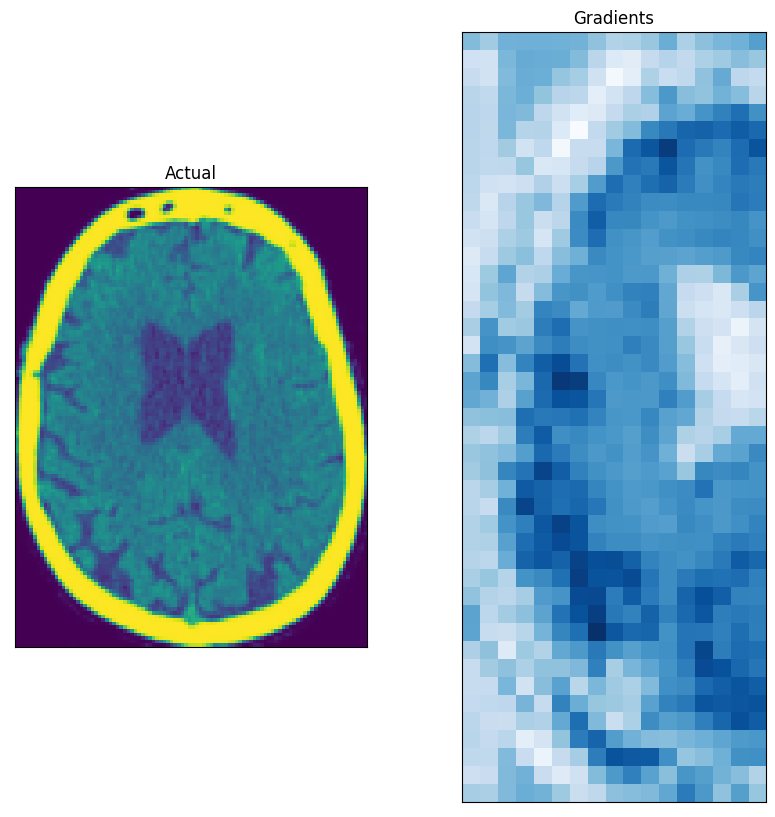

In [178]:
import matplotlib
import matplotlib.pyplot as plt

def plot_actual_and_heatmap(heatmap):
    cmap = matplotlib.cm.get_cmap("twilight_r")

    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(121)
    ax1.imshow(img[0].numpy().squeeze());
    ax1.set_title("Actual");
    ax1.set_xticks([],[]);ax1.set_yticks([],[]);

    ax2 = fig.add_subplot(122)
    ax2.imshow(heatmap, cmap="Blues");
    ax2.set_title("Gradients");
    ax2.set_xticks([],[]);ax2.set_yticks([],[]);

plot_actual_and_heatmap(heatmap.detach())

<AxesSubplot: >

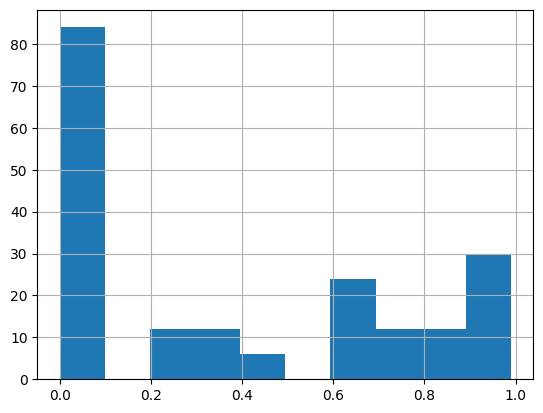

In [15]:
labels_preds.y_pred.hist()

In [16]:
threshold_best = model.find_threshold(labels_preds.y_pred,
                                          labels_preds.y_true)


/home/high_fly_bird/workspace/Ischemic_Stroke_Prediction/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/high_fly_bird/workspace/Ischemic_Stroke_Prediction/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [18]:
pred_bin = (labels_preds.y_pred > 0.5).astype(int)

In [22]:
labels_preds['pred_bin'] = pred_bin

In [27]:
labels_preds[(labels_preds.y_true==1)]

,y_true,y_pred,pred_bin


In [21]:
from sklearn.metrics import f1_score,precision_score


f1_score(y_true=labels_preds.y_true, y_pred=pred_bin)
precision_score(y_true=labels_preds.y_true, y_pred=pred_bin)

0.0

In [12]:
threshold_best

0.0

In [ ]:
labels_preds['pred_bin'] = (
        labels_preds.y_pred > threshold_best).astype(int)


In [ ]:
labels_preds

In [ ]:
model.get_layer

In [ ]:
gradModel = Model(
inputs=[model.inputs],
outputs=[model.get_layer(layer_name).output,
model.output])
with tf.GradientTape() as tape:
   # cast the image tensor to a float-32 data type, pass the
   # forward propagate the image through the gradient model, and grab the loss
   # associated with the specific class index
   inputs = tf.cast(img_array, tf.float32)
   (convOutputs, predictions) = gradModel(inputs)
   loss = predictions[:, 0]
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)
# compute the guided gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads
# the convolution and guided gradients have a batch dimension
# (which we don't need) so let's grab the volume itself and
# discard the batch
convOutputs = convOutputs[0]
guidedGrads = guidedGrads[0]
# compute the average of the gradient values, and using them
# as weights, compute the ponderation of the filters with
# respect to the weights
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (img_array.shape[2], img_array.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))
# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer
numer = heatmap - np.min(heatmap)
denom = (heatmap.max() - heatmap.min()) + eps
heatmap = numer / denom